In [ ]:
# Decision Forest (Random Forest): Parameters, How to Inspect, and How to Optimize
**Context:** Supply Chain — Late Delivery Classification

---

## 1) Parameter Cheat-Sheet

### Shared (Classifier & Regressor)
- `n_estimators` (int, default=100): Number of trees.  
- `criterion`: Split quality metric (see model-specific).  
- `max_depth` (int or None): Max tree depth.  
- `min_samples_split` (int/float, default=2): Min samples to split a node.  
- `min_samples_leaf` (int/float, default=1): Min samples at a leaf.  
- `min_weight_fraction_leaf` (float, default=0.0)  
- `max_features` ({int, float, "sqrt", "log2", None})  
- `max_leaf_nodes` (int or None)  
- `min_impurity_decrease` (float, default=0.0)  
- `bootstrap` (bool, default=True)  
- `oob_score` (bool, default=False)  
- `n_jobs` (int or None)  
- `random_state` (int or None)  
- `verbose` (int)  
- `warm_start` (bool)  
- `ccp_alpha` (float)  
- `max_samples` (int, float or None)  

### Classifier-only
- `class_weight` ({"balanced", "balanced_subsample"} or dict or None)  
- `criterion`: `"gini"`, `"entropy"`, `"log_loss"`

### Regressor-only
- `criterion`: `"squared_error"`, `"absolute_error"`, `"friedman_mse"`, `"poisson"`


In [1]:
# 2) Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import randint
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)


In [3]:
# 3) Create synthetic supply chain dataset
n = 800
lead_time_days         = np.random.randint(3, 40, size=n)
order_size             = np.random.randint(10, 1000, size=n)
supplier_reliability   = np.clip(np.random.normal(0.85, 0.1, size=n), 0, 1)
port_congestion_index  = np.clip(np.random.normal(0.4, 0.2, size=n), 0, 1)
is_promo               = np.random.binomial(1, 0.3, size=n)
distance_km            = np.random.randint(50, 3000, size=n)
historical_delay_rate  = np.clip(np.random.beta(2, 8, size=n), 0, 1)

logit = (
    0.04 * (lead_time_days - 15) +
    0.0005 * (order_size - 300) +
   -2.5 * (supplier_reliability - 0.85) +
    1.8 * (port_congestion_index - 0.4) +
    0.8 * (is_promo - 0.3) +
    0.0003 * (distance_km - 800) +
    2.0 * (historical_delay_rate - 0.2)
)
prob_late = 1 / (1 + np.exp(-logit))
late = (np.random.rand(n) < prob_late).astype(int)

df = pd.DataFrame({
    "LeadTime_Days": lead_time_days,
    "Order_Size": order_size,
    "Supplier_Reliability": supplier_reliability,
    "Port_Congestion": port_congestion_index,
    "Is_Promo": is_promo,
    "Distance_km": distance_km,
    "Hist_Delay_Rate": historical_delay_rate,
    "LateDelivery": late
})
df.head()


,LeadTime_Days,Order_Size,Supplier_Reliability,Port_Congestion,Is_Promo,Distance_km,Hist_Delay_Rate,LateDelivery
0,31,682,0.789537,0.496755,1,1855,0.108540,1
1,17,911,0.846905,0.352917,1,1019,0.219739,1
2,10,699,0.900673,0.457197,0,1144,0.076746,1
3,23,19,0.829929,0.314231,0,2078,0.143363,0
4,21,270,0.759396,0.134413,0,1454,0.212616,1


In [5]:
# 4) Train-test split
features = ["LeadTime_Days","Order_Size","Supplier_Reliability","Port_Congestion",
            "Is_Promo","Distance_km","Hist_Delay_Rate"]
X = df[features]
y = df["LateDelivery"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)


In [7]:
# 5) List all parameters
rf_clf = RandomForestClassifier(random_state=42)
print("Classifier params:", rf_clf.get_params())

rf_reg = RandomForestRegressor(random_state=42)
print("\nRegressor params:", rf_reg.get_params())


Classifier params: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Regressor params: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [9]:
# 6) Baseline model
rf_baseline = RandomForestClassifier(
    n_estimators=300, oob_score=True, bootstrap=True,
    random_state=42, n_jobs=-1
)
rf_baseline.fit(X_train, y_train)
print("OOB Score:", rf_baseline.oob_score_)
y_pred_base = rf_baseline.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred_base))


OOB Score: 0.6666666666666666
Test Accuracy: 0.635


In [11]:
# 7) RandomizedSearchCV optimization
rnd_param_dist = {
    "n_estimators": randint(200, 700),
    "max_depth": randint(4, 30),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 15),
    "max_features": ["sqrt", "log2", None, 0.5, 0.8],
    "bootstrap": [True, False],
    "class_weight": [None, "balanced", "balanced_subsample"],
}
rnd_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=rnd_param_dist,
    n_iter=20, scoring="accuracy", cv=5,
    random_state=42, n_jobs=-1, verbose=1
)
rnd_search.fit(X_train, y_train)
print("Best params:", rnd_search.best_params_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 587}


In [13]:
# 8) GridSearchCV refinement
best = rnd_search.best_params_
grid_param = {
    "n_estimators": [best["n_estimators"]-100, best["n_estimators"], best["n_estimators"]+100],
    "max_depth": [best["max_depth"]-2, best["max_depth"], best["max_depth"]+2],
    "min_samples_split": [best["min_samples_split"]-1, best["min_samples_split"], best["min_samples_split"]+1],
    "min_samples_leaf": [best["min_samples_leaf"]-1, best["min_samples_leaf"], best["min_samples_leaf"]+1],
    "max_features": [best["max_features"]],
    "bootstrap": [best["bootstrap"]],
    "class_weight": [best["class_weight"]],
}
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=grid_param, scoring="accuracy", cv=5,
    n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)
print("Best Grid params:", grid_search.best_params_)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Grid params: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 18, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 587}


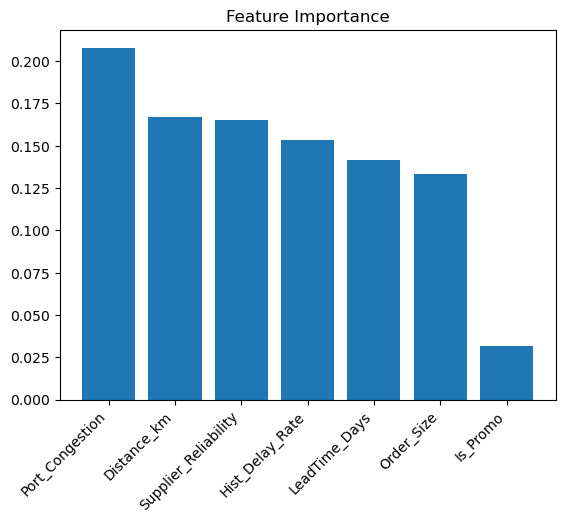

In [15]:
# 9) Feature importance plot
def plot_feature_importance(model, feature_names):
    importances = model.feature_importances_
    order = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[order])
    plt.xticks(range(len(importances)), np.array(feature_names)[order], rotation=45, ha="right")
    plt.title("Feature Importance")
    plt.show()

plot_feature_importance(grid_search.best_estimator_, features)
